# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, validation_curve
from sklearn.preprocessing import PolynomialFeatures

<AxesSubplot:xlabel='Year'>

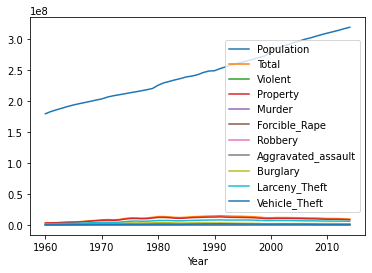

In [52]:
df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

<AxesSubplot:xlabel='Year'>

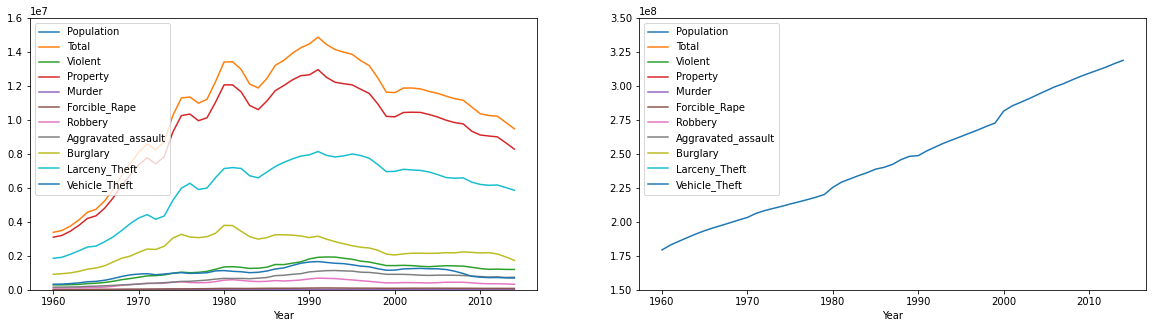

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
df..plot(ax=ax[0])
df.plot(ax=ax[1])

In [54]:
df = df.drop(['Total', 'Population'], axis=1)

<AxesSubplot:>

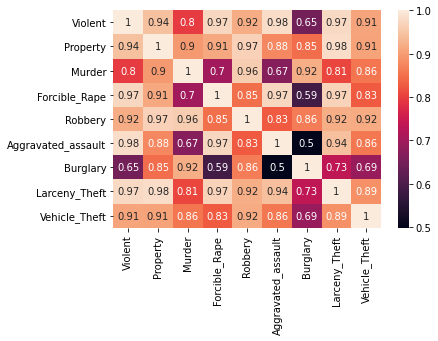

In [55]:
sns.heatmap(df.corr(), annot=True)

In [56]:
corr_serie = df.corr().stack()
corr_serie = corr_serie[~(corr_serie == 1)]
corr_serie.sort_values(ascending=False)['Murder'].head(5)

Robbery          0.960156
Burglary         0.920207
Property         0.895641
Vehicle_Theft    0.856600
Larceny_Theft    0.806279
dtype: float64

In [57]:
df = df[['Robbery', 'Burglary', 'Property', 'Vehicle_Theft', 'Larceny_Theft', 'Murder']]

In [58]:
df.head()

,Robbery,Burglary,Property,Vehicle_Theft,Larceny_Theft,Murder
Year,,,,,,
1960,107840,912100,3095700,328200,1855400,9110
1961,106670,949600,3198600,336000,1913000,8740
1962,110860,994300,3450700,366800,2089600,8530
1963,116470,1086400,3792500,408300,2297800,8640
1964,130390,1213200,4200400,472800,2514400,9360


In [61]:
X = df.iloc[:, :-1].copy()
target = df['Murder'].copy()

In [66]:
seed = 42

In [62]:
poly_trans = PolynomialFeatures(degree=6)
X_poly = poly_trans.fit_transform(X)


In [81]:
model = LinearRegression()

In [76]:
cv = RepeatedKFold(n_splits=5, n_repeats=7, random_state=seed)
for i in range(1, 28):
    cross_val_score(model, X_poly, target, cv=cv)
    model.score(X_poly, target)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.